Imports

In [217]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import find_edges
import os
import pockets_eval
import sam

%matplotlib inline
# %matplotlib qt

Input file

In [218]:
# Pro snooker
image_file = "./images/snooker1.png"
seed_point = np.array([750, 750])

In [219]:
# Casual snooker
image_file = "./images/snooker2.jpg"
seed_point = np.array([3000, 2000])

In [220]:
# Terrace phone
image_file = "./images/terrace_phone.jpg"
seed_point = np.array([1800, 800])
device = "s10+_horizontal"

Load and undistort image

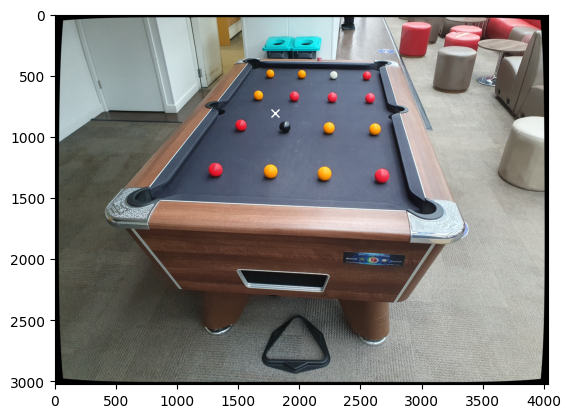

In [221]:
# Load
img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort image
mtx = np.load(os.path.join("./calibration", device, "intrinsic_matrix.npy"))
dist_coeffs = np.load(os.path.join("./calibration", device, "distortion.npy"))
undistorted_image_file = "./temp/undistorted.png"
img = cv2.undistort(img, mtx, dist_coeffs)
cv2.imwrite(undistorted_image_file, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
image_file = undistorted_image_file

# Undistort seed point
seed_point = cv2.undistortImagePoints(seed_point.astype(np.float32), mtx, dist_coeffs)[0][0]
seed_point = seed_point.astype(np.int16)

# Draw
plt.figure()
plt.imshow(img)
plt.plot(*seed_point, "wx")

Smooth

In [222]:
# Calculate the size of the Gaussian kernel based on 1/4 of the smaller side of the image
smaller_side = min(img.shape[0], img.shape[1])
gaussian_kernel_size = max(3, smaller_side // 30)
if gaussian_kernel_size % 2 == 0:
    gaussian_kernel_size += 1

gaussian_kernel_size = 3

# Apply Gaussian smoothing to the masked difference image
# img = cv2.GaussianBlur(img, (gaussian_kernel_size, gaussian_kernel_size), 0)

Create mask

In [223]:
# Meaningless mask
mask = np.zeros([0, 0])

Device: cpu


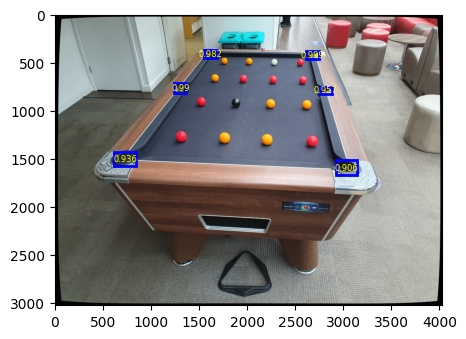

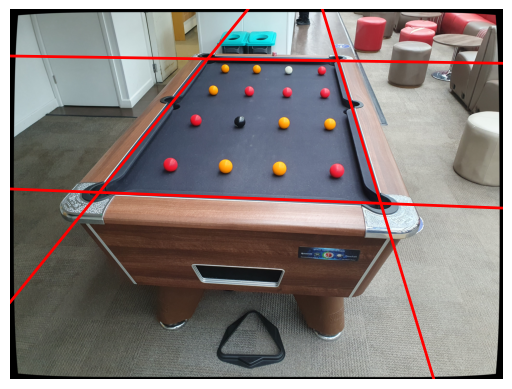

In [224]:
# Execute NN for masking
pockets = pockets_eval.evaluate(image_file)
pocket_lines, pocket_mask, min_dist = find_edges.get_lines_from_pockets(image_file, pockets)

In [225]:
# Reverse projection mask
table_size = np.array([0.903, 1.676]) # English 8 ball
dilation_distance = 0.1 # 10cm

corners = find_edges.get_rect_corners(pocket_lines)
rvec, tvec, projection = find_edges.get_perspective(corners, table_size, mtx)

table_world_points = np.array([
    [-dilation_distance, table_size[1]+dilation_distance],
    [table_size[0]+dilation_distance, table_size[1]+dilation_distance],
    [table_size[0]+dilation_distance, -dilation_distance],
    [-dilation_distance, -dilation_distance]
])
corners = find_edges.get_img_pos_from_perspective(table_world_points, mtx, rvec, tvec, 0)

# Make mask
pocket_mask = np.zeros(img.shape[:2], dtype=np.uint8)
corners = np.array([corners], dtype=np.int32)
_ = cv2.fillPoly(pocket_mask, corners, color=1)  # Set color to 1 for binary mask

In [226]:
# Dilated NN mask
pocket_mask = find_edges.dilate(pocket_mask, int(min_dist / 10))

# sam.show_mask(pocket_mask, plt.gca())

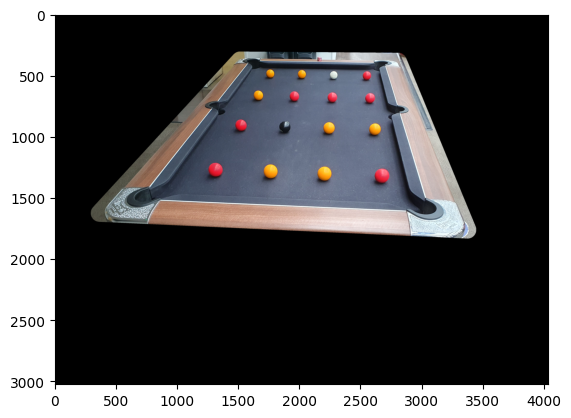

In [227]:
# Apply mask to image

# mask = cv2.copyMakeBorder(pocket_mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
img = cv2.bitwise_and(img, img, mask=pocket_mask)

plt.figure()
plt.imshow(img)

Flood fill

In [228]:
# Hue image
diff = 3

# Get val
img_val = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:, :, 0].copy()

retval, out_img, out_mask, rect = cv2.floodFill(img_val, mask, seed_point, 0, diff, diff, flags=cv2.FLOODFILL_MASK_ONLY)

In [229]:
# Colour image
diff = (5, 5, 5)

retval, out_img, out_mask, rect = cv2.floodFill(img, mask, seed_point, (255, 255, 255), diff, diff, flags=cv2.FLOODFILL_MASK_ONLY)

Draw

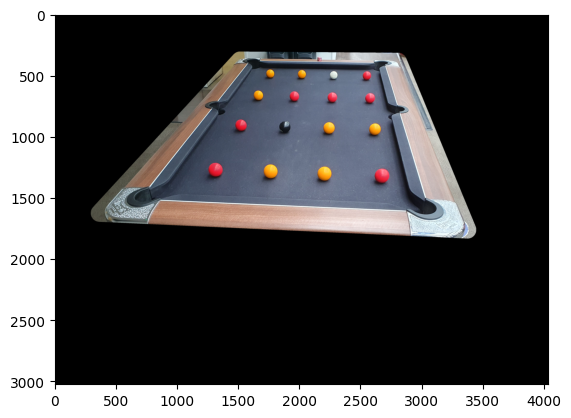

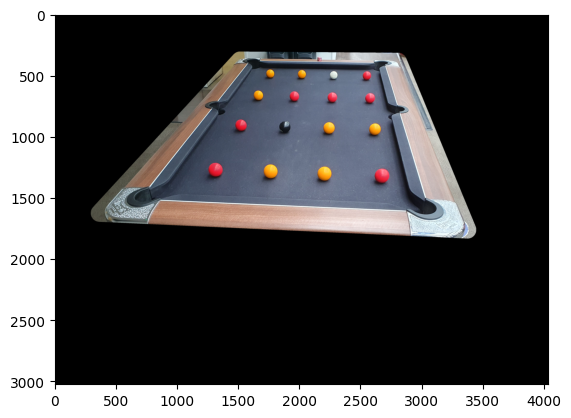

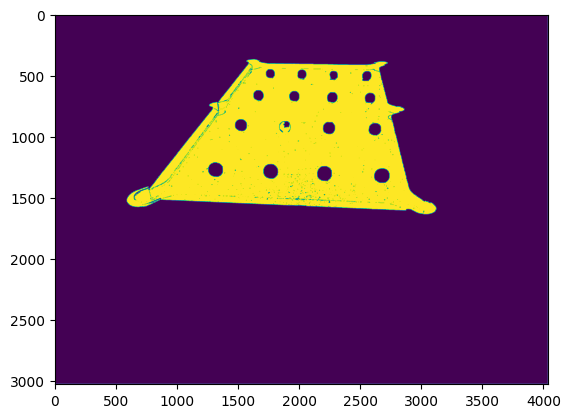

In [230]:
# %matplotlib qt
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(out_img)
plt.figure()
plt.imshow(out_mask)

Chop off edges

In [231]:
out_mask = out_mask[1:-1, 1:-1]

Apply Hough lines

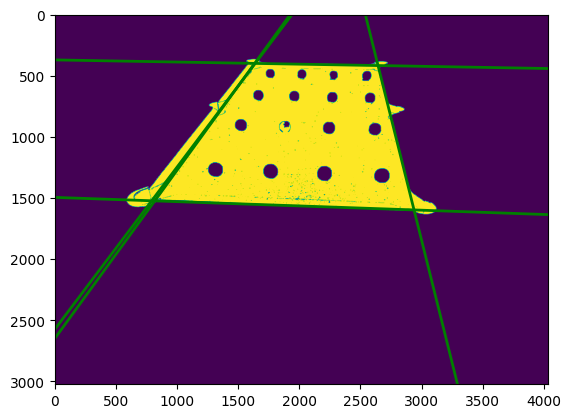

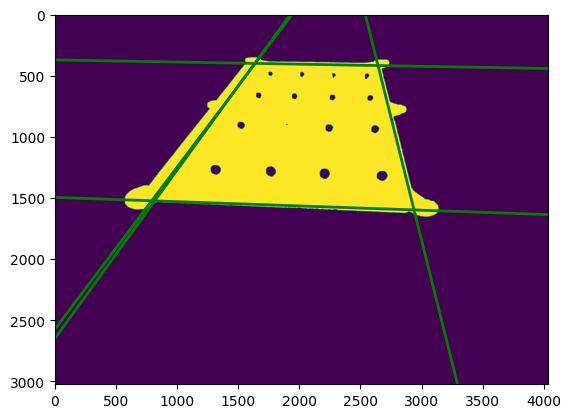

In [232]:
mask_file = "./temp/flood_mask.png"
# cv2.imwrite(mask_file, out_mask)
np.savetxt(mask_file, out_mask, fmt='%.0f')

# %matplotlib qt
_ = find_edges.get_sam_lines(mask_file)